# BraTS 2021 – Dataset Exploration

This notebook explores the BraTS 2021 brain tumor segmentation dataset:

In [1]:
import os
from pathlib import Path
from collections import Counter

import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

%matplotlib inline

DATASET_ROOT = Path("../dataset")

MODALITY_SUFFIXES = {
    "t1": "_t1.nii.gz",
    "t1ce": "_t1ce.nii.gz",
    "t2": "_t2.nii.gz",
    "flair": "_flair.nii.gz",
    "seg": "_seg.nii.gz",
}

In [2]:
subject_dirs = sorted(
    [p for p in DATASET_ROOT.glob("*") if p.is_dir()]
)

print(f"Found {len(subject_dirs)} subject folders.")

for p in subject_dirs[:5]:
    print(p.name)

Found 1251 subject folders.
BraTS2021_00000
BraTS2021_00002
BraTS2021_00003
BraTS2021_00005
BraTS2021_00006


In [3]:
def get_files_for_subject(subject_dir, modality_suffixes=MODALITY_SUFFIXES):
    """Return dict of modality -> Path for one subject, if file exists."""
    files = {}
    for modality, suffix in modality_suffixes.items():
        candidates = list(subject_dir.glob(f"*{suffix}"))
        files[modality] = candidates[0] if candidates else None
    return files

example_subject = subject_dirs[0]
example_files = get_files_for_subject(example_subject)

print("Example subject:", example_subject.name)
for modality, path in example_files.items():
    print(f"  {modality:5s} -> {path.name if path is not None else 'MISSING'}")

Example subject: BraTS2021_00000
  t1    -> BraTS2021_00000_t1.nii.gz
  t1ce  -> BraTS2021_00000_t1ce.nii.gz
  t2    -> BraTS2021_00000_t2.nii.gz
  flair -> BraTS2021_00000_flair.nii.gz
  seg   -> BraTS2021_00000_seg.nii.gz


In [4]:
def load_nifti(path):
    """Load a NIfTI file and return (image, data_array)."""
    img = nib.load(str(path))
    data = np.asanyarray(img.dataobj)
    return img, data

def show_axial_slice(volume, slice_index=None, title="", cmap="gray", vmin=None, vmax=None):
    """
    Show one axial slice (slice along the z-axis: volume[:, :, k]).
    If slice_index is None, uses the middle slice.
    """
    if slice_index is None:
        slice_index = volume.shape[2] // 2

    slice_2d = volume[:, :, slice_index]
    
    plt.figure(figsize=(5, 5))
    plt.imshow(np.rot90(slice_2d), cmap=cmap, vmin=vmin, vmax=vmax)
    plt.axis("off")
    plt.title(f"{title} | slice {slice_index}")
    plt.show()

def overlay_segmentation(base_volume, seg_volume, slice_index=None, title=""):
    """
    Overlay segmentation labels on top of a base MRI slice.
    Assumes BraTS label encoding:
      0: background
      1: necrotic / non-enhancing tumor core (NCR/NET)
      2: peritumoral edema (ED)
      4: enhancing tumor (ET)
    """
    if slice_index is None:
        slice_index = base_volume.shape[2] // 2

    base = base_volume[:, :, slice_index]
    seg = seg_volume[:, :, slice_index]

    # Normalize base for nicer visualization
    base_norm = base.copy()
    if np.std(base_norm) > 0:
        base_norm = (base_norm - np.mean(base_norm)) / np.std(base_norm)

    base_norm = np.clip(base_norm, -2, 2)

    # Define a simple color map for labels
    # 0: transparent; 1: red; 2: green; 4: blue
    label_colors = {
        0: (0, 0, 0, 0),
        1: (1, 0, 0, 0.5),
        2: (0, 1, 0, 0.5),
        4: (0, 0, 1, 0.5),
    }

    rgba_seg = np.zeros((seg.shape[0], seg.shape[1], 4), dtype=float)
    for label, color in label_colors.items():
        mask = seg == label
        rgba_seg[mask] = color

    plt.figure(figsize=(6, 6))
    plt.imshow(np.rot90(base_norm), cmap="gray")
    plt.imshow(np.rot90(rgba_seg), interpolation="none")
    plt.axis("off")
    plt.title(f"{title} | slice {slice_index}")
    plt.show()


Subject: BraTS2021_00000
  t1    -> BraTS2021_00000_t1.nii.gz
  t1ce  -> BraTS2021_00000_t1ce.nii.gz
  t2    -> BraTS2021_00000_t2.nii.gz
  flair -> BraTS2021_00000_flair.nii.gz
  seg   -> BraTS2021_00000_seg.nii.gz
t1    shape: (240, 240, 155), dtype: int16
t1ce  shape: (240, 240, 155), dtype: int16
t2    shape: (240, 240, 155), dtype: int16
flair shape: (240, 240, 155), dtype: int16
seg   shape: (240, 240, 155), dtype: uint8


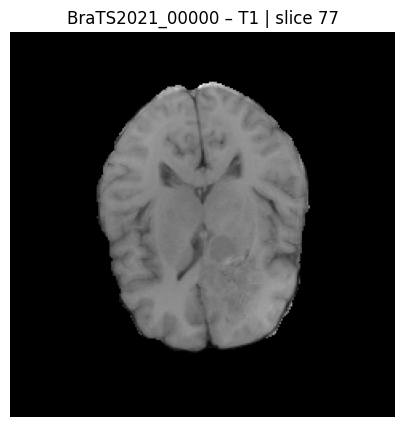

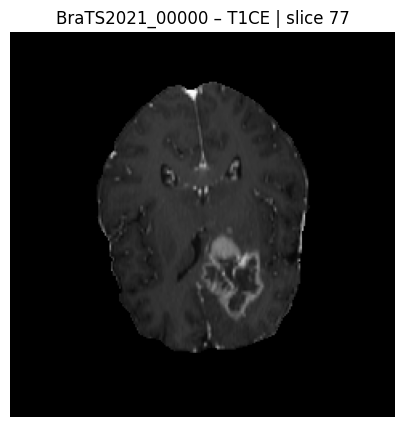

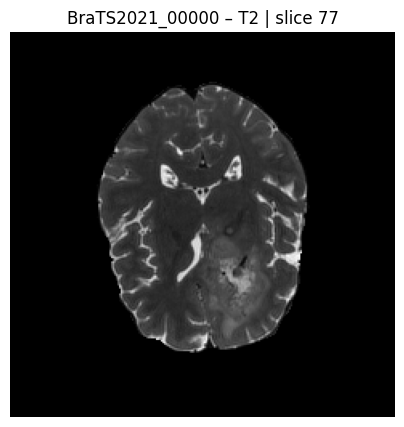

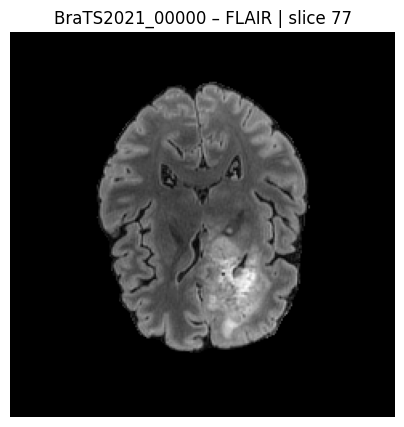

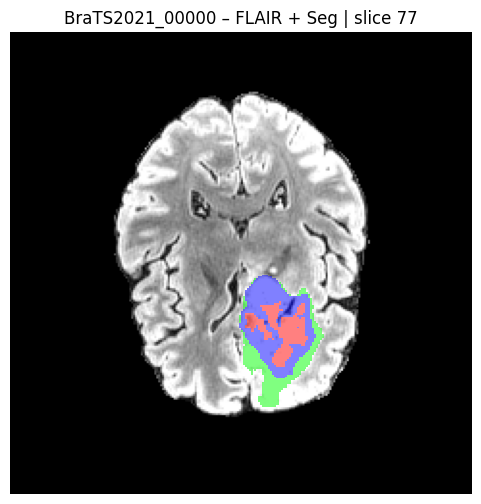

In [5]:
subject_idx = 0
subject_dir = subject_dirs[subject_idx]
files = get_files_for_subject(subject_dir)

print("Subject:", subject_dir.name)
for k, v in files.items():
    print(f"  {k:5s} ->", v.name if v is not None else "MISSING")

imgs = {}
volumes = {}
for modality in ["t1", "t1ce", "t2", "flair", "seg"]:
    path = files.get(modality)
    if path is None:
        print(f"WARNING: {modality} missing")
        continue
    img, data = load_nifti(path)
    imgs[modality] = img
    volumes[modality] = data
    print(f"{modality:5s} shape: {data.shape}, dtype: {data.dtype}")

slice_index = volumes["flair"].shape[2] // 2

for modality in ["t1", "t1ce", "t2", "flair"]:
    if modality in volumes:
        show_axial_slice(
            volumes[modality],
            slice_index=slice_index,
            title=f"{subject_dir.name} – {modality.upper()}",
        )

if "seg" in volumes and "flair" in volumes:
    overlay_segmentation(
        volumes["flair"],
        volumes["seg"],
        slice_index=slice_index,
        title=f"{subject_dir.name} – FLAIR + Seg",
    )


Subject: BraTS2021_00705
  t1    -> BraTS2021_00705_t1.nii.gz
  t1ce  -> BraTS2021_00705_t1ce.nii.gz
  t2    -> BraTS2021_00705_t2.nii.gz
  flair -> BraTS2021_00705_flair.nii.gz
  seg   -> BraTS2021_00705_seg.nii.gz
t1    shape: (240, 240, 155), dtype: int16
t1ce  shape: (240, 240, 155), dtype: int16
t2    shape: (240, 240, 155), dtype: int16
flair shape: (240, 240, 155), dtype: int16
seg   shape: (240, 240, 155), dtype: uint16


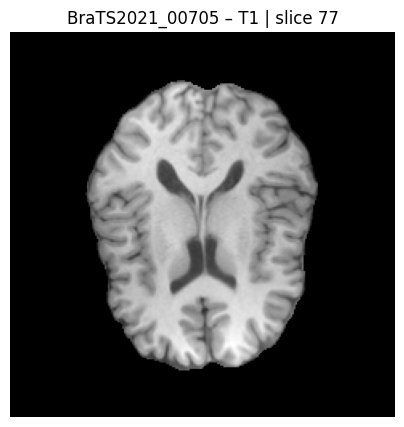

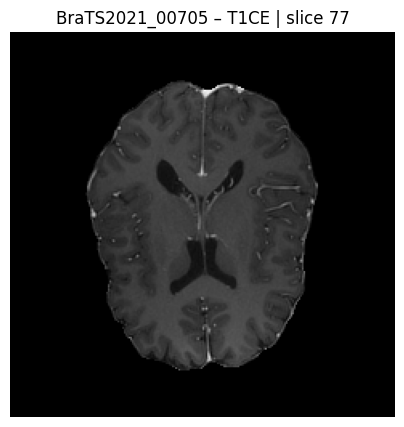

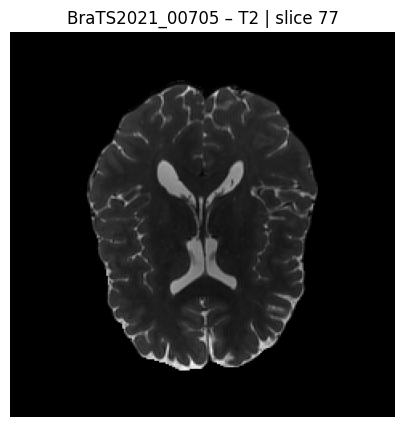

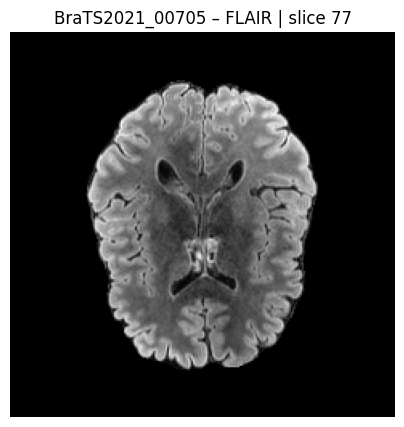

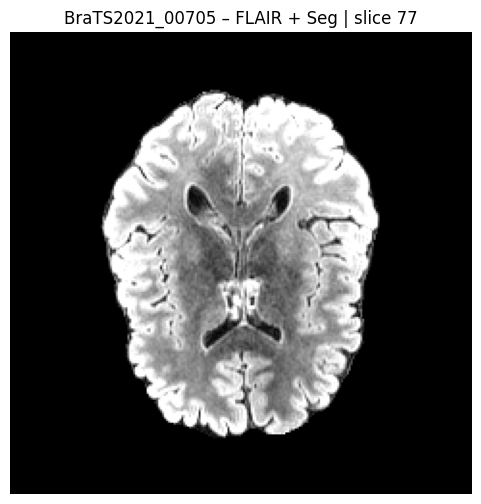

In [6]:
subject_idx = 495
subject_dir = subject_dirs[subject_idx]
files = get_files_for_subject(subject_dir)

print("Subject:", subject_dir.name)
for k, v in files.items():
    print(f"  {k:5s} ->", v.name if v is not None else "MISSING")

imgs = {}
volumes = {}
for modality in ["t1", "t1ce", "t2", "flair", "seg"]:
    path = files.get(modality)
    if path is None:
        print(f"WARNING: {modality} missing")
        continue
    img, data = load_nifti(path)
    imgs[modality] = img
    volumes[modality] = data
    print(f"{modality:5s} shape: {data.shape}, dtype: {data.dtype}")

slice_index = volumes["flair"].shape[2] // 2

for modality in ["t1", "t1ce", "t2", "flair"]:
    if modality in volumes:
        show_axial_slice(
            volumes[modality],
            slice_index=slice_index,
            title=f"{subject_dir.name} – {modality.upper()}",
        )

if "seg" in volumes and "flair" in volumes:
    overlay_segmentation(
        volumes["flair"],
        volumes["seg"],
        slice_index=slice_index,
        title=f"{subject_dir.name} – FLAIR + Seg",
    )


In [7]:
def collect_basic_metadata(subject_dirs):
    shapes = Counter()
    dtypes = Counter()
    missing_modalities = Counter()

    for subject_dir in subject_dirs:
        files = get_files_for_subject(subject_dir)
        for modality in ["t1", "t1ce", "t2", "flair", "seg"]:
            path = files.get(modality)
            if path is None:
                missing_modalities[modality] += 1
                continue

            try:
                img = nib.load(str(path))
                data = np.asanyarray(img.dataobj)
                shapes[(modality, data.shape)] += 1
                dtypes[(modality, data.dtype)] += 1
            except Exception as e:
                print(f"Error loading {path}: {e}")

    return shapes, dtypes, missing_modalities

shapes, dtypes, missing_mods = collect_basic_metadata(subject_dirs)

print("=== Volume shapes (modality, shape) -> count ===")
for (mod, shape), count in shapes.items():
    print(f"{mod:5s} {shape}: {count}")

print("\n=== Data types (modality, dtype) -> count ===")
for (mod, dt), count in dtypes.items():
    print(f"{mod:5s} {dt}: {count}")

print("\n=== Missing modalities (modality -> #subjects missing) ===")
for mod, count in missing_mods.items():
    print(f"{mod:5s}: {count}")

=== Volume shapes (modality, shape) -> count ===
t1    (240, 240, 155): 1251
t1ce  (240, 240, 155): 1251
t2    (240, 240, 155): 1251
flair (240, 240, 155): 1251
seg   (240, 240, 155): 1251

=== Data types (modality, dtype) -> count ===
t1    int16: 1060
t1ce  int16: 1059
t2    int16: 1062
flair int16: 1059
seg   uint8: 427
seg   uint16: 753
t1    float32: 191
t1ce  float32: 192
t2    float32: 189
flair float32: 192
seg   int16: 71

=== Missing modalities (modality -> #subjects missing) ===


In [8]:
def compute_label_distribution(subject_dirs, max_subjects=None):
    """
    Count voxel labels across segmentation masks.
    BraTS labels:
      0: background
      1: necrotic / non-enhancing core (NCR/NET)
      2: peritumoral edema (ED)
      4: enhancing tumor (ET)
    """
    label_counts = Counter()
    n_processed = 0

    for i, subject_dir in enumerate(subject_dirs):
        if max_subjects is not None and i >= max_subjects:
            break

        files = get_files_for_subject(subject_dir)
        seg_path = files.get("seg")
        if seg_path is None:
            continue

        try:
            _, seg = load_nifti(seg_path)
            unique, counts = np.unique(seg, return_counts=True)
            label_counts.update(dict(zip(unique.astype(int), counts)))
            n_processed += 1
        except Exception as e:
            print(f"Error loading seg for {subject_dir.name}: {e}")

    return label_counts, n_processed

label_counts, n_seg = compute_label_distribution(subject_dirs, max_subjects=None)

print(f"Processed {n_seg} subjects with segmentation.")

total_voxels = sum(label_counts.values())
print("\nLabel distribution (voxel counts and percentages):")
for label in sorted(label_counts.keys()):
    count = label_counts[label]
    pct = 100.0 * count / total_voxels if total_voxels > 0 else 0.0
    print(f"Label {label}: {count:,} voxels ({pct:.2f}%)")


Processed 1251 subjects with segmentation.

Label distribution (voxel counts and percentages):
Label 0: 11,048,872,504 voxels (98.93%)
Label 1: 17,896,396 voxels (0.16%)
Label 2: 75,328,509 voxels (0.67%)
Label 4: 26,830,591 voxels (0.24%)


In [9]:
def compute_intensity_stats(subject_dirs, max_subjects=200):
    stats = {m: [] for m in ["t1", "t1ce", "t2", "flair"]}

    for i, subject_dir in enumerate(subject_dirs):
        if max_subjects is not None and i >= max_subjects:
            break

        files = get_files_for_subject(subject_dir)
        for modality in stats.keys():
            path = files.get(modality)
            if path is None:
                continue
            try:
                _, vol = load_nifti(path)
                nonzero = vol[vol != 0]
                if nonzero.size > 0:
                    stats[modality].append(
                        (float(np.mean(nonzero)), float(np.std(nonzero)))
                    )
            except Exception as e:
                print(f"Error loading {path}: {e}")

    summary = {}
    for modality, values in stats.items():
        if not values:
            continue
        means = np.array([v[0] for v in values])
        stds = np.array([v[1] for v in values])
        summary[modality] = {
            "mean_of_means": float(means.mean()),
            "std_of_means": float(means.std()),
            "mean_of_stds": float(stds.mean()),
            "std_of_stds": float(stds.std()),
            "n_subjects": len(values),
        }
    return summary

def intensity_summary_to_df(summary):
    df = pd.DataFrame.from_dict(summary, orient="index")
    cols = ["n_subjects", "mean_of_means", "std_of_means", "mean_of_stds", "std_of_stds"]
    df = df[cols]
    df.index.name = "modality"
    return df

def pretty_print_intensity_summary_pandas(summary):
    df = intensity_summary_to_df(summary)
    # Round for nicer display
    df_rounded = df.round({
        "mean_of_means": 3,
        "std_of_means": 3,
        "mean_of_stds": 3,
        "std_of_stds": 3,
    })
    print(df_rounded.to_string())


intensity_summary = compute_intensity_stats(subject_dirs, max_subjects=None)
df = intensity_summary_to_df(intensity_summary)
df.style.format("{:.3f}")


NameError: name 'pd' is not defined